## COGS 181 Final Project - Few Shot Learning with CIFAR-10 Data

### Overview of Experiment:
- Running Few-Shot Learning on CIFAR-10 Dataset 
- Using two models: AlexNet and ResNet
- Few-Shot Learning Steps:
  1. Subset data into few-shot data sets into k classes with n samples, for each k sample has query set
  2. run model on the subset of the data, record train error and validation error 
  3. after training is done, we run the model on the test set and record test error
  4. repeat for all subsets to get an avg score for train, validatio, test error

#### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

#### Import Data - CIFAR-10

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


tensor([7, 3, 1, 1])


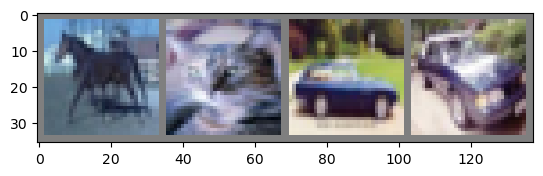

('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
horse   cat   car   car


In [19]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(labels)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(classes)
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cpu


In [15]:
#Subset Train and Test Data
classes_of_interest = ['cat', 'dog', 'bird', 'frog', 'deer', 'horse']
labels_of_interest = [3, 5, 2, 6, 4, 7]
#label_indices = [trainset.class_to_idx[label] for label in labels_of_interest]
train_subset = [img for img in trainset if img[1] in labels_of_interest]
test_subset = [img for img in testset if img[1] in labels_of_interest]

In [16]:
class FewShotDataset(Dataset):
    def __init__(self, dataset, classes, num_samples):
        self.dataset = dataset
        self.classes = classes
        self.num_samples = num_samples
        self.data = self._create_few_shot_dataset()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data, label = self.data[index]
        return data, label

    def _create_few_shot_dataset(self):
        few_shot_data = []
        for class_name in self.classes:
            class_indices = np.where(np.array(self.dataset.targets) == self.dataset.class_to_idx[class_name])[0]
            selected_indices = np.random.choice(class_indices, self.num_samples, replace=False)
            for idx in selected_indices:
                data, label = self.dataset.data[idx], self.dataset.targets[idx]
                few_shot_data.append((data, label))
        return few_shot_data

In [17]:
# Define classes and number of samples for training tasks
train_classes_task1 = ['cat', 'dog']
train_num_samples_task1 = 3
train_classes_task2 = ['horse', 'deer']
train_num_samples_task2 = 3

# Define classes and number of samples for test tasks
test_classes_task1 = ['frog', 'bird']
test_num_samples_task1 = 3

# Create FewShotDataset instances for training and test tasks
train_task1_dataset = FewShotDataset(trainset, train_classes_task1, train_num_samples_task1)
train_task2_dataset = FewShotDataset(trainset, train_classes_task2, train_num_samples_task2)
test_task1_dataset = FewShotDataset(testset, test_classes_task1, test_num_samples_task1)

# Create training and test tasks
train_tasks = [(train_task1_dataset, train_task1_dataset, None), (train_task2_dataset, train_task2_dataset, None)]
test_tasks = [(test_task1_dataset, test_task1_dataset, None)]

In [21]:
# Iterate over train tasks
for task_idx, task in enumerate(train_tasks):
    task_dataset = task[0]  # Extract dataset from the task tuple
    print(f"Training Task {task_idx + 1}:")
    print("Number of samples:", len(task_dataset))
    # Iterate over samples in the dataset
    for sample_idx, (data, label) in enumerate(task_dataset):
        print(f"Sample {sample_idx + 1}:")
        print("Label:", label)
        # You can visualize or process the data here as needed

Training Task 1:
Number of samples: 6
Sample 1:
Label: 3
Sample 2:
Label: 3
Sample 3:
Label: 3
Sample 4:
Label: 5
Sample 5:
Label: 5
Sample 6:
Label: 5
Training Task 2:
Number of samples: 6
Sample 1:
Label: 7
Sample 2:
Label: 7
Sample 3:
Label: 7
Sample 4:
Label: 4
Sample 5:
Label: 4
Sample 6:
Label: 4
